In [4]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

args = edict({
    'img_size': 64,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/ot/data/handbag2shoes_train',
    'val_img_dir': '/cache/selikhanovych/ot/data/handbag2shoes_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': '/cache/selikhanovych/ot/checkpoints/stargan-v2/handbag_shoes_64/checkpoints',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'shoes',
    'OUTPUT_PATH': '/cache/selikhanovych/ot/checkpoints/stargan-v2/handbag_shoes_64',
    'domains': {
        'source': 'handbag',
        'target': 'shoes',
    },
    'train_a': '/cache/selikhanovych/ot/data/handbag2shoes_train_handbag',
    'train_b': '/cache/selikhanovych/ot/data/handbag2shoes_train_shoes', 
    'test_a': '/cache/selikhanovych/ot/data/handbag2shoes_test_handbag',
    'test_b': '/cache/selikhanovych/ot/data/handbag2shoes_test_shoes',
    
    'n_epochs': 1
})


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)
print(domains)

1 0
['handbag', 'shoes']


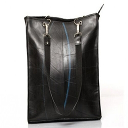

In [5]:
from PIL import Image
from glob import glob

path_to_image = "/cache/selikhanovych/ot/data/handbag2shoes_train/handbag"
images = glob(os.path.join(path_to_image, "*"))

Image.open(images[100])

In [6]:
cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)
assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains
loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

Number of parameters of generator: 32634883
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20327808
Number of parameters of discriminator: 20263170
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...


Computing FID


  0%|          | 0/376 [00:00<?, ?it/s]

Calculating evaluation metrics...
Number of domains: 2
Compute FID for handbag2shoes
Preparing DataLoader for the generation phase...


100%|██████████| 376/376 [01:31<00:00,  4.13it/s]


FID = 37.32570225912275, best FID = 38.73429012906007, best iter = 24000
Plotting, iter = 28000
mode = train


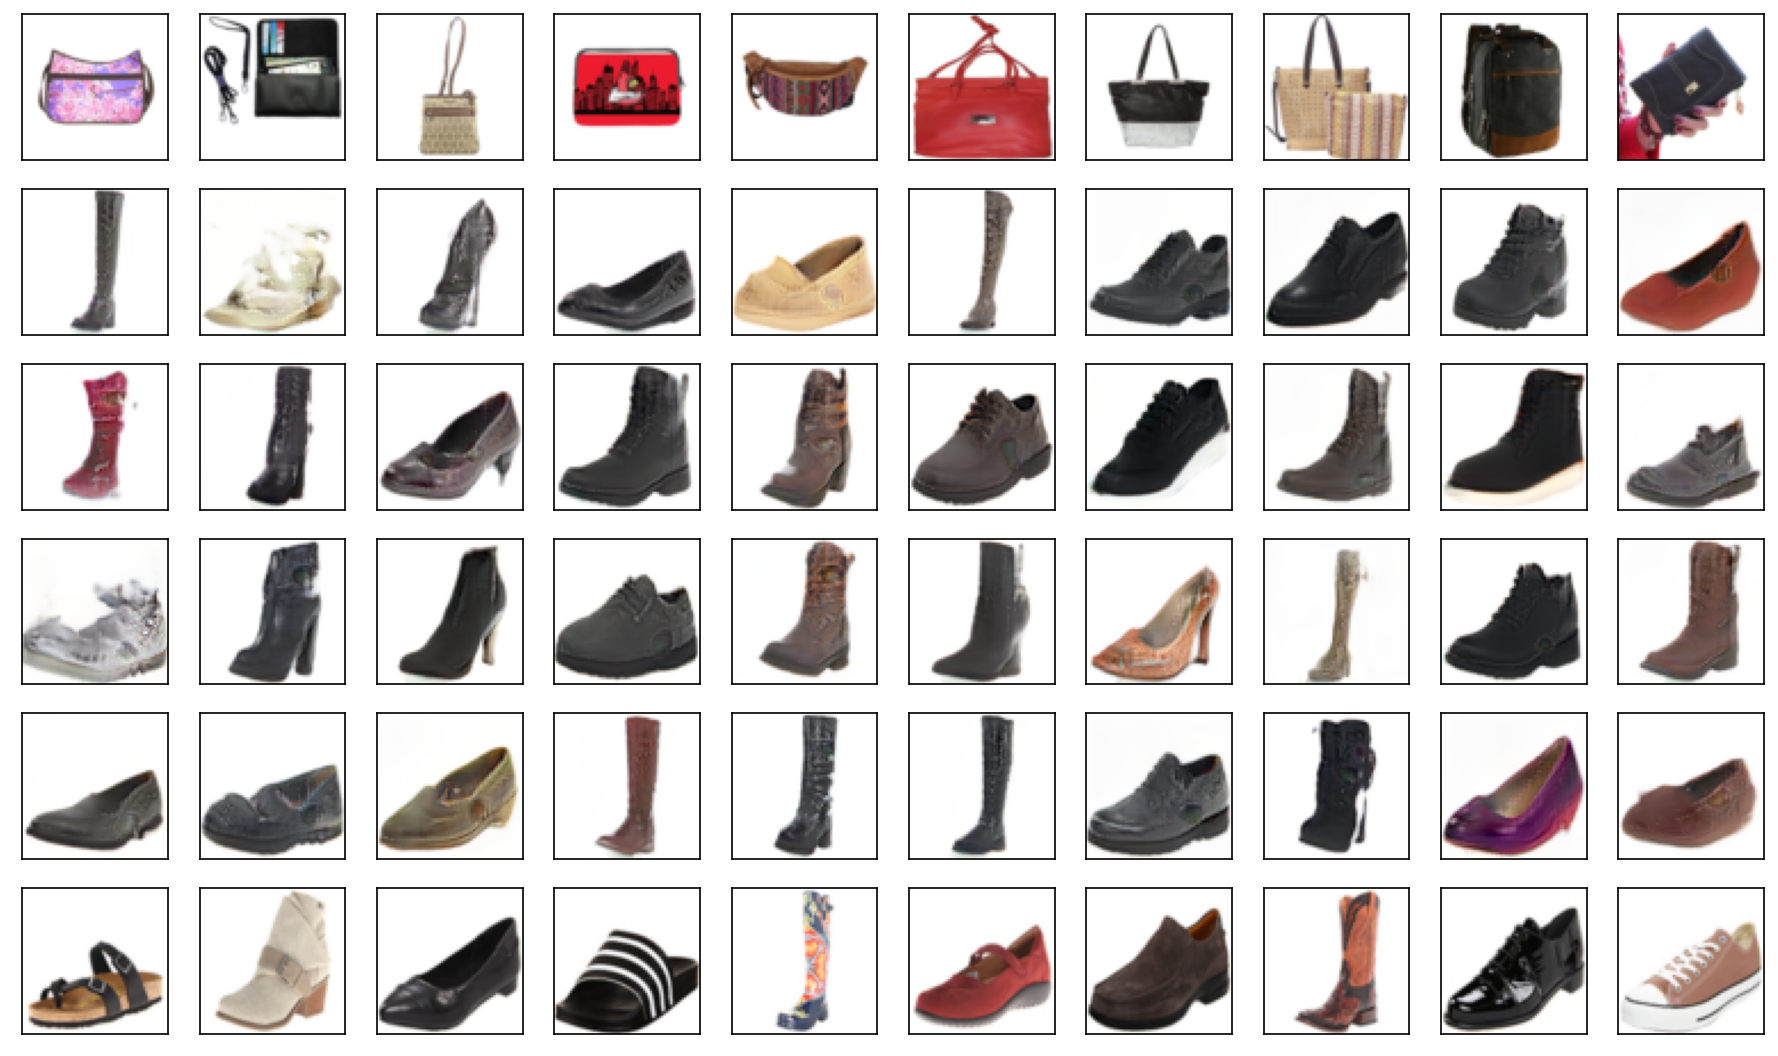

mode = test


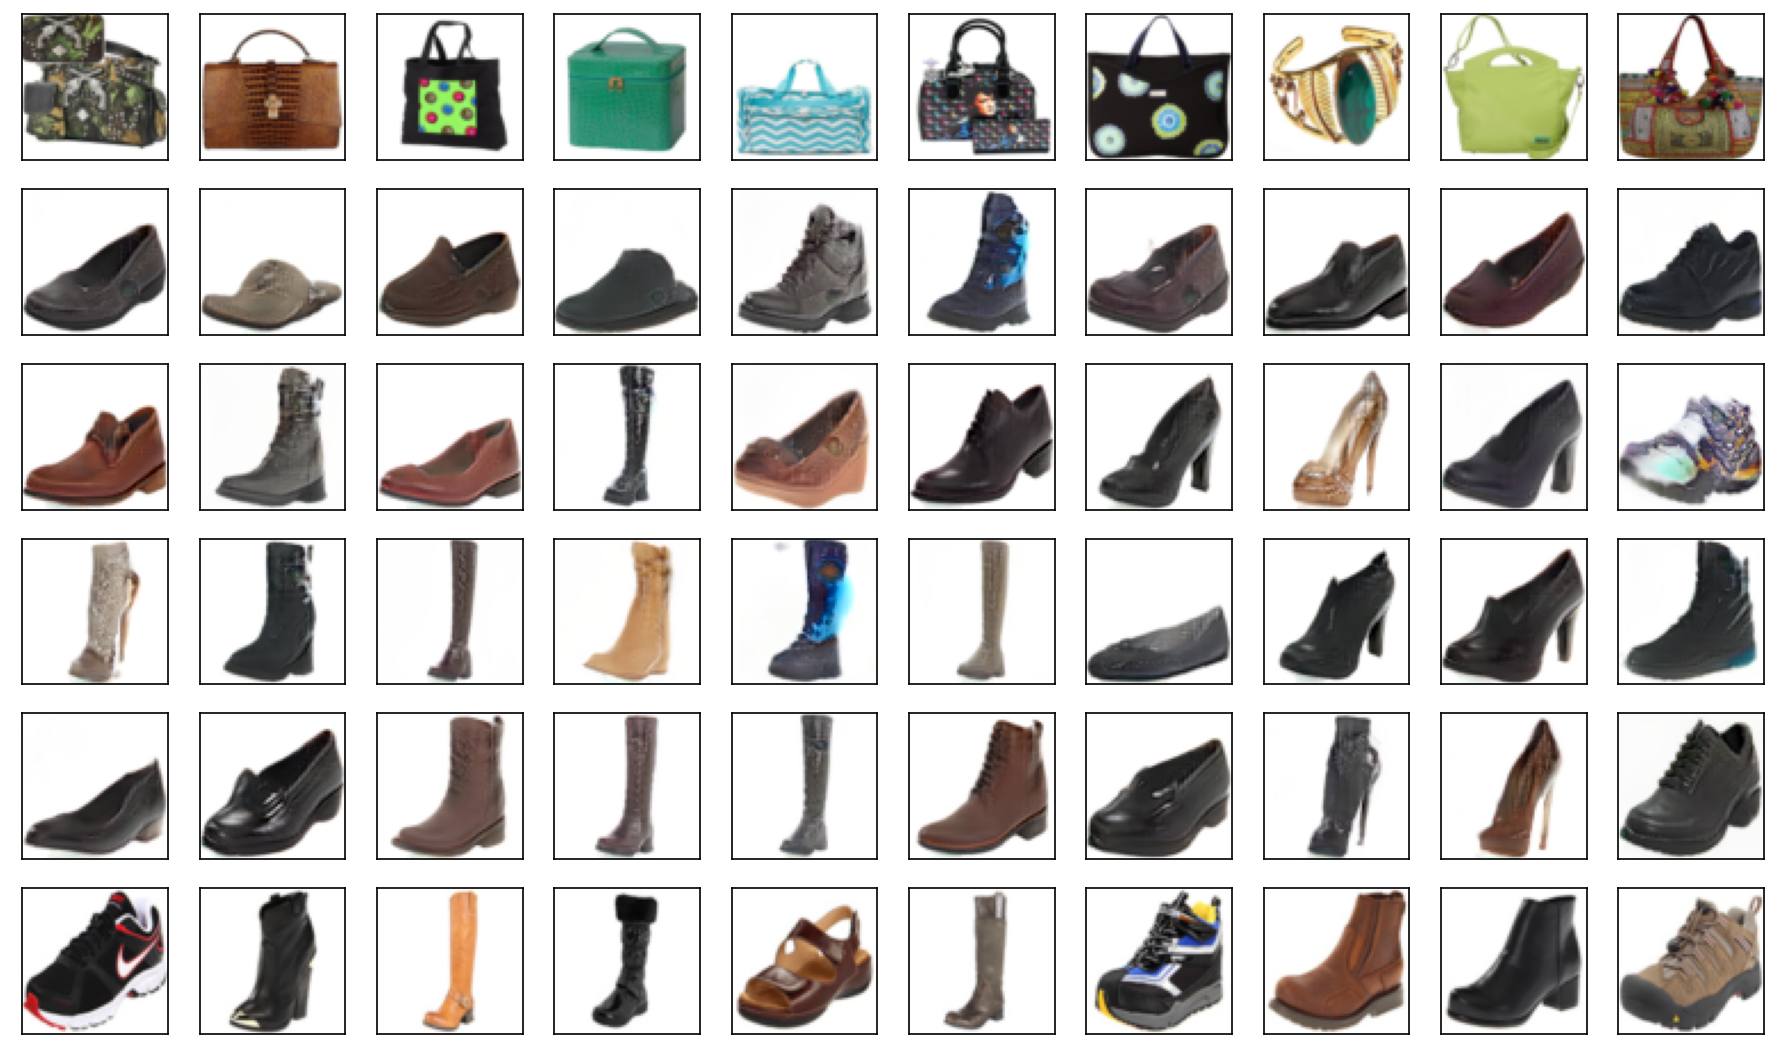

Elapsed time [22:34:14], Iteration [28011/100000], D/latent_real: [0.7714] D/latent_fake: [0.5492] D/latent_reg: [0.0568] D/ref_real: [0.5096] D/ref_fake: [0.5074] D/ref_reg: [0.0466] G/latent_adv: [1.0751] G/latent_sty: [0.2085] G/latent_ds: [0.3121] G/latent_cyc: [0.1307] G/ref_adv: [1.1874] G/ref_sty: [0.1195] G/ref_ds: [0.4423] G/ref_cyc: [0.1467] G/lambda_ds: [0.7199]
Elapsed time [22:34:45], Iteration [28021/100000], D/latent_real: [0.8724] D/latent_fake: [0.3725] D/latent_reg: [0.0585] D/ref_real: [0.2819] D/ref_fake: [0.7631] D/ref_reg: [0.0575] G/latent_adv: [1.4016] G/latent_sty: [0.2330] G/latent_ds: [0.4142] G/latent_cyc: [0.1674] G/ref_adv: [1.4743] G/ref_sty: [0.1231] G/ref_ds: [0.3456] G/ref_cyc: [0.1513] G/lambda_ds: [0.7198]
Elapsed time [22:35:12], Iteration [28031/100000], D/latent_real: [0.8179] D/latent_fake: [0.4790] D/latent_reg: [0.0387] D/ref_real: [0.4265] D/ref_fake: [0.6583] D/ref_reg: [0.0391] G/latent_adv: [1.2748] G/latent_sty: [0.2287] G/latent_ds: [0.31

Elapsed time [22:44:49], Iteration [28231/100000], D/latent_real: [0.6869] D/latent_fake: [0.5977] D/latent_reg: [0.0497] D/ref_real: [0.3886] D/ref_fake: [0.5741] D/ref_reg: [0.0489] G/latent_adv: [1.1483] G/latent_sty: [0.2174] G/latent_ds: [0.3426] G/latent_cyc: [0.1930] G/ref_adv: [1.0812] G/ref_sty: [0.1213] G/ref_ds: [0.4640] G/ref_cyc: [0.1859] G/lambda_ds: [0.7177]
Elapsed time [22:45:19], Iteration [28241/100000], D/latent_real: [0.8933] D/latent_fake: [0.3611] D/latent_reg: [0.0702] D/ref_real: [0.1855] D/ref_fake: [1.0255] D/ref_reg: [0.0612] G/latent_adv: [1.5636] G/latent_sty: [0.2269] G/latent_ds: [0.3884] G/latent_cyc: [0.1528] G/ref_adv: [1.5844] G/ref_sty: [0.1146] G/ref_ds: [0.3577] G/ref_cyc: [0.1625] G/lambda_ds: [0.7176]
Elapsed time [22:45:47], Iteration [28251/100000], D/latent_real: [0.7484] D/latent_fake: [0.5166] D/latent_reg: [0.0480] D/ref_real: [0.4881] D/ref_fake: [0.5475] D/ref_reg: [0.0478] G/latent_adv: [1.2670] G/latent_sty: [0.2380] G/latent_ds: [0.46

Elapsed time [22:55:27], Iteration [28451/100000], D/latent_real: [0.8031] D/latent_fake: [0.5442] D/latent_reg: [0.0656] D/ref_real: [0.4284] D/ref_fake: [0.7102] D/ref_reg: [0.0560] G/latent_adv: [1.2205] G/latent_sty: [0.2329] G/latent_ds: [0.2985] G/latent_cyc: [0.1729] G/ref_adv: [1.1256] G/ref_sty: [0.1234] G/ref_ds: [0.3221] G/ref_cyc: [0.1653] G/lambda_ds: [0.7155]
Elapsed time [22:55:56], Iteration [28461/100000], D/latent_real: [0.5701] D/latent_fake: [0.7194] D/latent_reg: [0.0521] D/ref_real: [0.4496] D/ref_fake: [0.3846] D/ref_reg: [0.0497] G/latent_adv: [1.2886] G/latent_sty: [0.2267] G/latent_ds: [0.4513] G/latent_cyc: [0.1690] G/ref_adv: [1.2658] G/ref_sty: [0.1143] G/ref_ds: [0.3331] G/ref_cyc: [0.1534] G/lambda_ds: [0.7154]
Elapsed time [22:56:23], Iteration [28471/100000], D/latent_real: [0.5698] D/latent_fake: [0.6080] D/latent_reg: [0.0486] D/ref_real: [0.3862] D/ref_fake: [0.5428] D/ref_reg: [0.0542] G/latent_adv: [1.3981] G/latent_sty: [0.2454] G/latent_ds: [0.31

Elapsed time [23:06:03], Iteration [28671/100000], D/latent_real: [0.6703] D/latent_fake: [0.5004] D/latent_reg: [0.0643] D/ref_real: [0.4517] D/ref_fake: [0.5258] D/ref_reg: [0.0624] G/latent_adv: [1.5387] G/latent_sty: [0.2497] G/latent_ds: [0.4250] G/latent_cyc: [0.1442] G/ref_adv: [1.2729] G/ref_sty: [0.1108] G/ref_ds: [0.3390] G/ref_cyc: [0.1317] G/lambda_ds: [0.7133]
Elapsed time [23:06:31], Iteration [28681/100000], D/latent_real: [1.0345] D/latent_fake: [0.3961] D/latent_reg: [0.0450] D/ref_real: [0.3903] D/ref_fake: [0.5697] D/ref_reg: [0.0489] G/latent_adv: [1.1679] G/latent_sty: [0.2270] G/latent_ds: [0.4280] G/latent_cyc: [0.1634] G/ref_adv: [1.1704] G/ref_sty: [0.1372] G/ref_ds: [0.4860] G/ref_cyc: [0.1444] G/lambda_ds: [0.7132]
Elapsed time [23:06:59], Iteration [28691/100000], D/latent_real: [0.6350] D/latent_fake: [0.5779] D/latent_reg: [0.0573] D/ref_real: [0.3553] D/ref_fake: [0.5723] D/ref_reg: [0.0553] G/latent_adv: [1.4461] G/latent_sty: [0.2374] G/latent_ds: [0.37

Elapsed time [23:16:37], Iteration [28891/100000], D/latent_real: [0.8195] D/latent_fake: [0.4190] D/latent_reg: [0.0528] D/ref_real: [0.3528] D/ref_fake: [0.7364] D/ref_reg: [0.0542] G/latent_adv: [1.4755] G/latent_sty: [0.2372] G/latent_ds: [0.3237] G/latent_cyc: [0.1366] G/ref_adv: [1.3161] G/ref_sty: [0.1458] G/ref_ds: [0.3154] G/ref_cyc: [0.1292] G/lambda_ds: [0.7111]
Elapsed time [23:17:07], Iteration [28901/100000], D/latent_real: [0.9897] D/latent_fake: [0.3313] D/latent_reg: [0.0502] D/ref_real: [0.2798] D/ref_fake: [0.7790] D/ref_reg: [0.0552] G/latent_adv: [1.3709] G/latent_sty: [0.2373] G/latent_ds: [0.3696] G/latent_cyc: [0.1663] G/ref_adv: [1.2960] G/ref_sty: [0.1597] G/ref_ds: [0.2646] G/ref_cyc: [0.1538] G/lambda_ds: [0.7110]
Elapsed time [23:17:35], Iteration [28911/100000], D/latent_real: [0.8029] D/latent_fake: [0.5422] D/latent_reg: [0.0507] D/ref_real: [0.4248] D/ref_fake: [0.4559] D/ref_reg: [0.0500] G/latent_adv: [1.3926] G/latent_sty: [0.2354] G/latent_ds: [0.34

Elapsed time [23:27:11], Iteration [29111/100000], D/latent_real: [0.7271] D/latent_fake: [0.5310] D/latent_reg: [0.0707] D/ref_real: [0.3432] D/ref_fake: [0.6519] D/ref_reg: [0.0696] G/latent_adv: [1.4208] G/latent_sty: [0.2158] G/latent_ds: [0.2557] G/latent_cyc: [0.1663] G/ref_adv: [1.3323] G/ref_sty: [0.0998] G/ref_ds: [0.3319] G/ref_cyc: [0.1561] G/lambda_ds: [0.7089]
Elapsed time [23:27:40], Iteration [29121/100000], D/latent_real: [0.6959] D/latent_fake: [0.5078] D/latent_reg: [0.0530] D/ref_real: [0.3832] D/ref_fake: [0.5554] D/ref_reg: [0.0461] G/latent_adv: [1.3274] G/latent_sty: [0.2180] G/latent_ds: [0.3972] G/latent_cyc: [0.1758] G/ref_adv: [1.1695] G/ref_sty: [0.1013] G/ref_ds: [0.3445] G/ref_cyc: [0.1628] G/lambda_ds: [0.7088]
Elapsed time [23:28:10], Iteration [29131/100000], D/latent_real: [0.6251] D/latent_fake: [0.8688] D/latent_reg: [0.0725] D/ref_real: [0.5892] D/ref_fake: [0.4111] D/ref_reg: [0.0520] G/latent_adv: [1.5038] G/latent_sty: [0.2068] G/latent_ds: [0.42

In [ ]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        print('Computing FID')
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for i in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[i][j]

                    axes[i + 1][j].imshow(cur_img)
                    axes[i + 1][j].get_xaxis().set_visible(False)
                    axes[i + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()